In [1]:
%load_ext autoreload
%autoreload 2

## Images to Vectors 

In [2]:
import os
import re

import numpy as np
import pandas as pd
from sklearn import preprocessing
from tqdm.auto import tqdm

from meezer.helpers import Img2Vec

In [3]:
input_path = '/meezer/data/labelled_faces/'
files = os.listdir(input_path)

In [4]:
img2vec = Img2Vec()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
test_image = os.path.join(input_path, files[0])
vec = img2vec.get_vec(test_image)

vec_length = vec.shape[0]

In [6]:
# Matrix to hold the image vectors
X = np.zeros((len(files), vec_length))

print('Reading images...')
for index, file in tqdm(enumerate(files)):
    filename = os.fsdecode(file)
    vec = img2vec.get_vec(os.path.join(input_path, filename))
    X[index, :] = vec

Reading images...


In [14]:
reg_ex_pat = r'([^/]+)_\d+.jpeg$'

cleaned_filenames = [re.findall(reg_ex_pat, filename)[0] for filename in files]

## Test Data Split 

In [15]:
face_to_holdout = 'lois_Death_Has_a_Shadow'

cleaned_filenames_array = np.array(cleaned_filenames)

train_idxs = np.argwhere(cleaned_filenames_array != face_to_holdout).flatten()
test_idxs = np.argwhere(cleaned_filenames_array == face_to_holdout).flatten()

X_train = X[train_idxs]
X_test = X[test_idxs]
filenames_train = cleaned_filenames_array[train_idxs]
filenames_test = cleaned_filenames_array[test_idxs]

In [16]:
le = preprocessing.LabelEncoder()

labels = le.fit_transform(filenames_train)

In [17]:
pd.Series(labels).value_counts()

73    124
82    123
13    120
66    118
79    117
     ... 
45      5
51      5
46      5
59      4
92      2
Length: 95, dtype: int64

## Train a Model 

In [18]:
from meezer import Meezer

In [19]:
model = Meezer(embedding_dims=2,
               k=15,
               distance='pn',
               batch_size=128,
               epochs=14,
               sub_epochs=9,
               margin=6,
               ntrees=100,
               search_k=-1,
               model='maaten',
               supervision_metric='sparse_categorical_crossentropy',
               supervision_weight=0.,
               annoy_index_path='annoy.index',
               early_stopping=True,
               reduce_lr_amount=0.94,
               verbose=True)

In [20]:
model.hard_mode = False

In [21]:
embeddings = model.fit_transform(X=X_train, Y=labels)

Building KNN index...



Extracting KNN from index...



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training neural network...


Epoch 0: loss 1.4855351512385655
New learning rate set to: 0.0009400000562891364
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 1: loss 0.7699783352073502
New learning rate set to: 0.0008836000342853367
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 2: loss 0.5733923203842294
New learning rate set to: 0.0008305840310640633
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 3: loss 0.4410990658520103
New learning rate set to: 0.00078074901830405
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 4: loss 0.3610159872552464
New learning rate set to: 0.0007339040748775005
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 5: loss 0.26642439278407676
New learning rate set to: 0.0006898698047734797
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 6: loss 0.2550590

In [22]:
test_embeddings = model.transform(X_test)

76/76 [==============================] - 0s 267us/sample


## Visualize Embeddings 

In [23]:
import matplotlib
import matplotlib.pyplot as plt

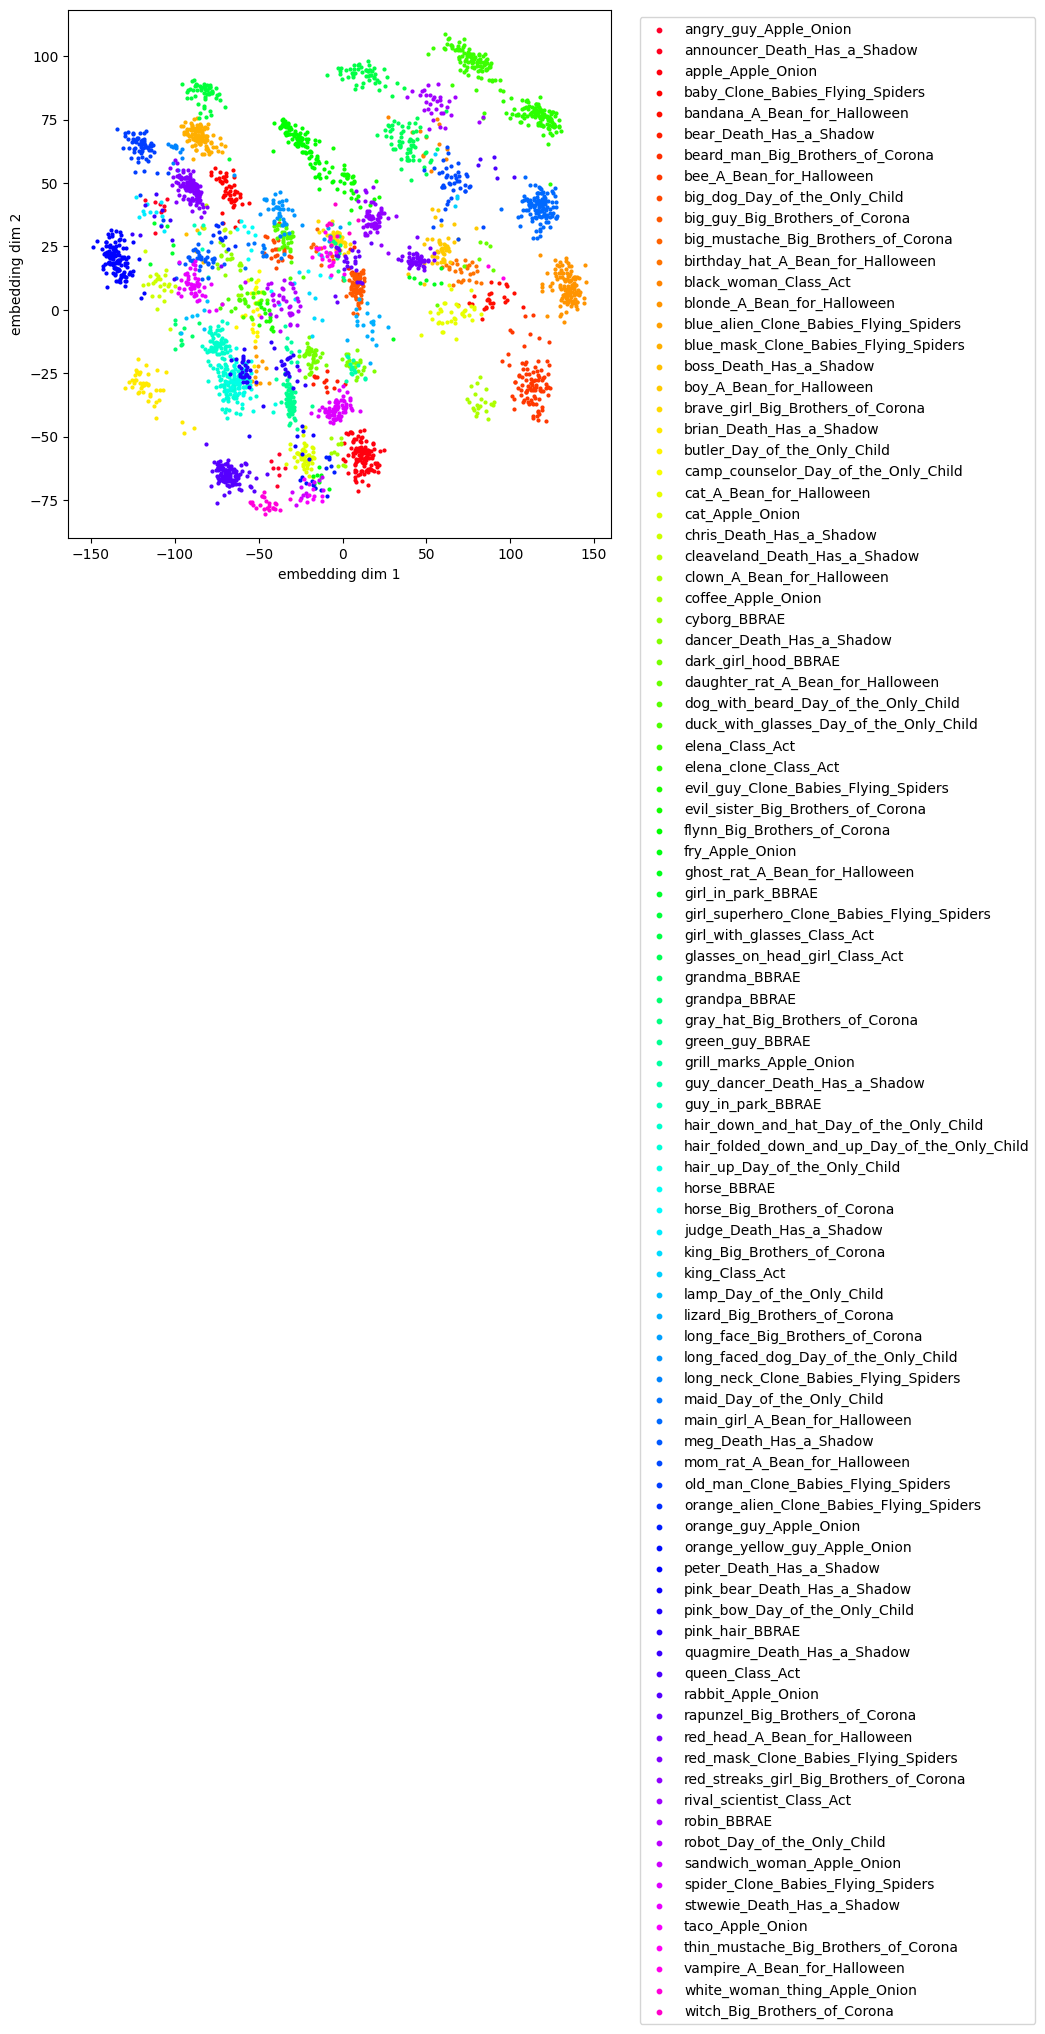

In [37]:
plt.figure(figsize=(7, 7), dpi=100)

cmap = plt.cm.gist_rainbow

for i, label in enumerate(np.sort(np.unique(labels))):
    #if 'Death_Has_a_Shadow' in le.classes_[i]:
        label_idxs = np.argwhere(labels == label)
        plt.scatter(embeddings[label_idxs, 0],
                    embeddings[label_idxs, 1],
                    s=4,
                    color=cmap(i / len(np.unique(labels))),
                    label=le.classes_[i])

plt.xlabel('embedding dim 1')
plt.ylabel('embedding dim 2')
lgnd = plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')

for handle in lgnd.legendHandles:
    handle.set_sizes([10])

plt.show()

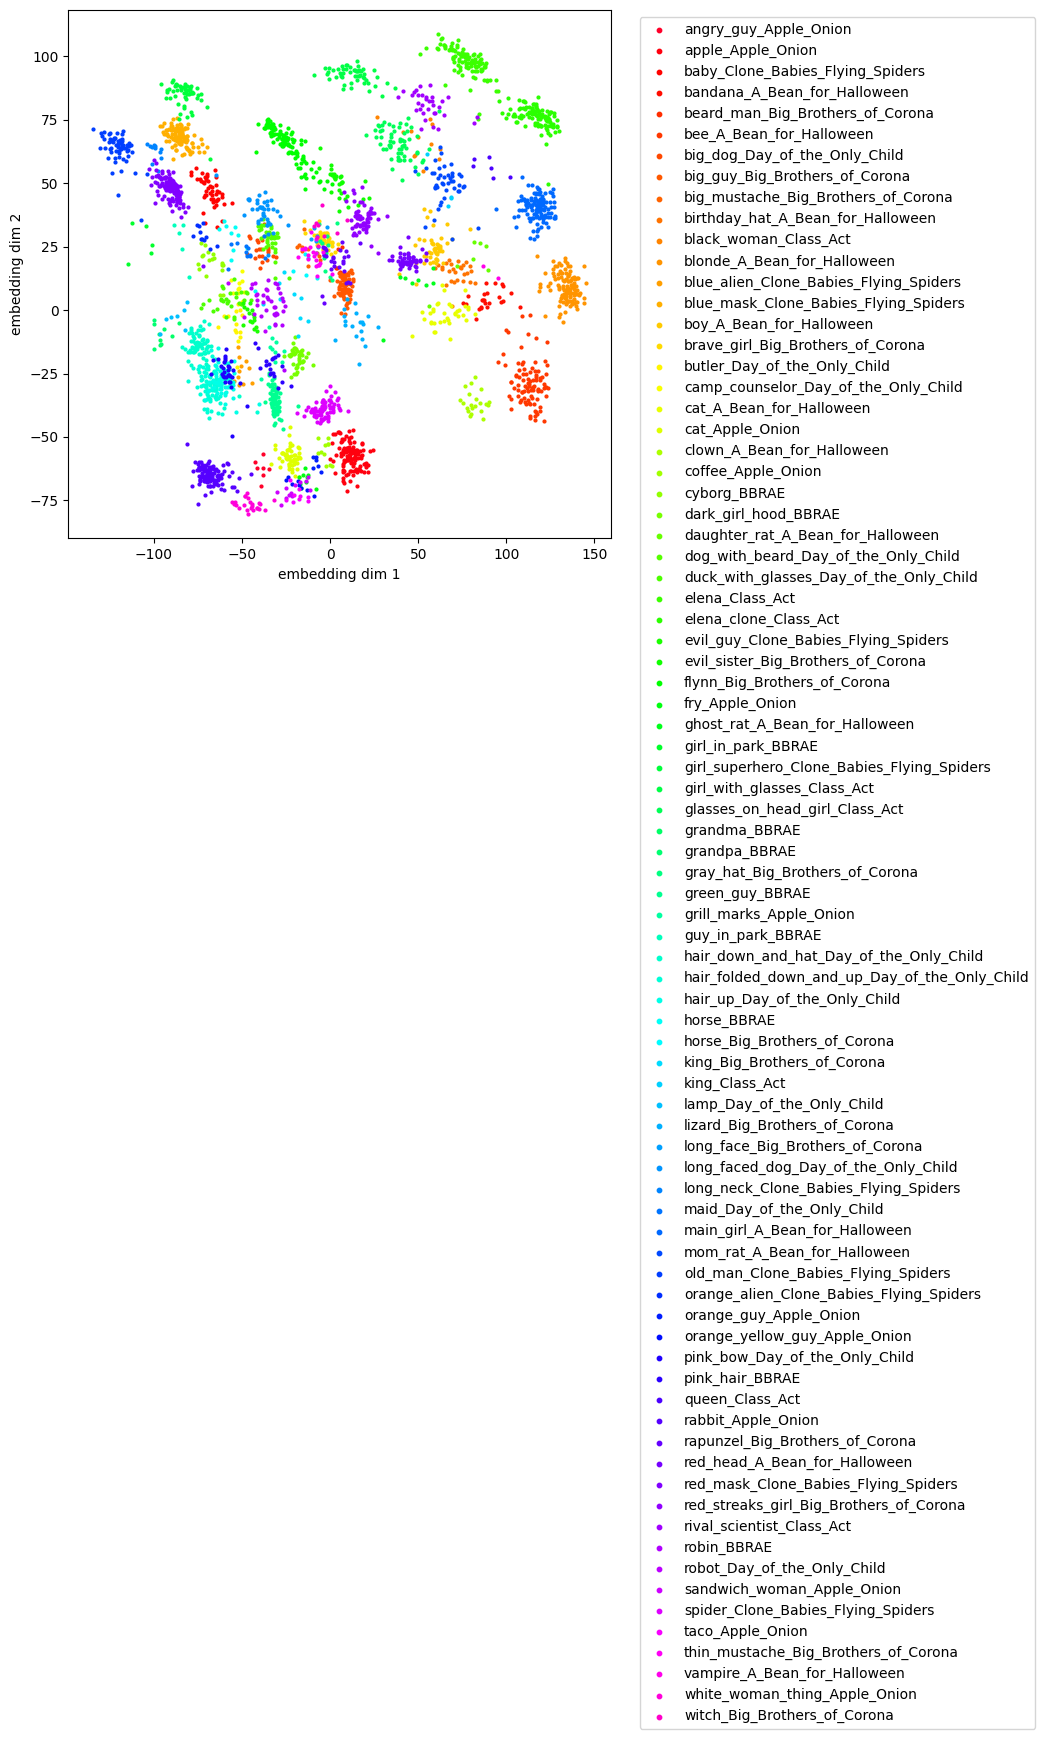

In [38]:
plt.figure(figsize=(7, 7), dpi=100)

cmap = plt.cm.gist_rainbow

for i, label in enumerate(np.sort(np.unique(labels))):
    if 'Death_Has_a_Shadow' not in le.classes_[i]:
        label_idxs = np.argwhere(labels == label)
        plt.scatter(embeddings[label_idxs, 0],
                    embeddings[label_idxs, 1],
                    s=4,
                    color=cmap(i / len(np.unique(labels))),
                    label=le.classes_[i])

plt.xlabel('embedding dim 1')
plt.ylabel('embedding dim 2')
lgnd = plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')

for handle in lgnd.legendHandles:
    handle.set_sizes([10])

plt.show()

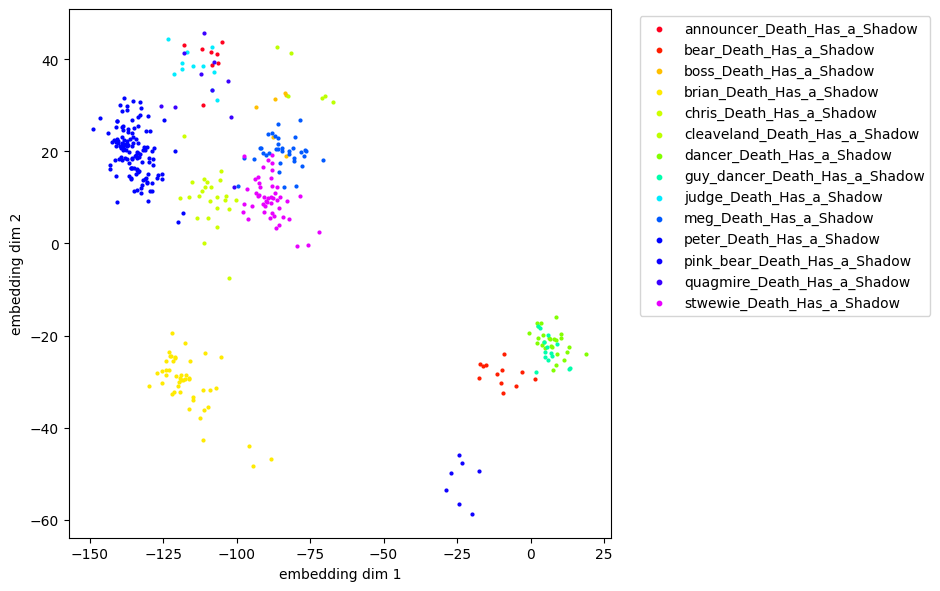

In [39]:
plt.figure(figsize=(7, 7), dpi=100)

cmap = plt.cm.gist_rainbow

for i, label in enumerate(np.sort(np.unique(labels))):
    if 'Death_Has_a_Shadow' in le.classes_[i]:
        label_idxs = np.argwhere(labels == label)
        plt.scatter(embeddings[label_idxs, 0],
                    embeddings[label_idxs, 1],
                    s=4,
                    color=cmap(i / len(np.unique(labels))),
                    label=le.classes_[i])

plt.xlabel('embedding dim 1')
plt.ylabel('embedding dim 2')
lgnd = plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')

for handle in lgnd.legendHandles:
    handle.set_sizes([10])

plt.show()

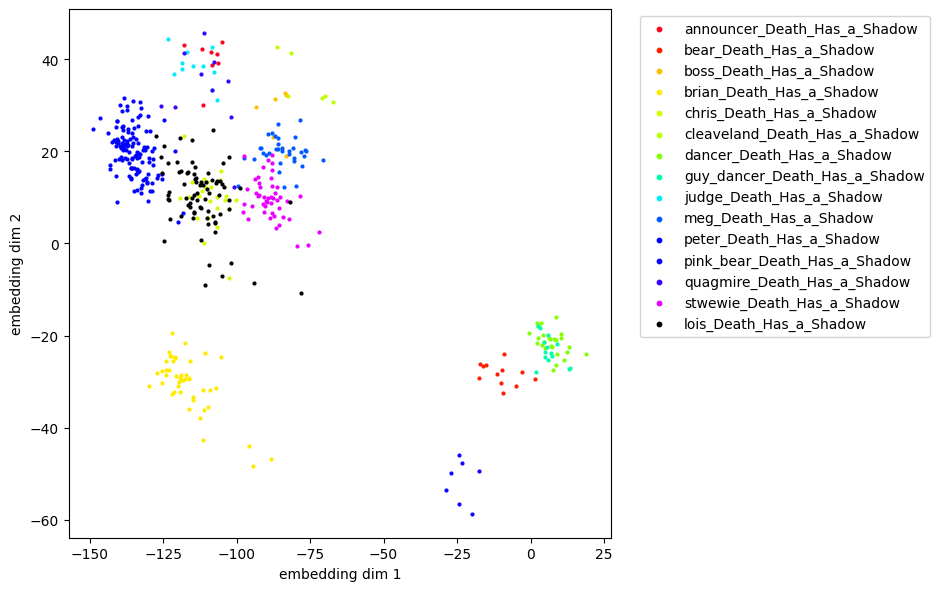

In [40]:
plt.figure(figsize=(7, 7), dpi=100)

cmap = plt.cm.gist_rainbow

for i, label in enumerate(np.sort(np.unique(labels))):
    if 'Death_Has_a_Shadow' in le.classes_[i]:
        label_idxs = np.argwhere(labels == label)
        plt.scatter(embeddings[label_idxs, 0],
                    embeddings[label_idxs, 1],
                    s=4,
                    color=cmap(i / len(np.unique(labels))),
                    label=le.classes_[i])

plt.scatter(test_embeddings[:, 0],
            test_embeddings[:, 1],
            s=4,
            color='black',
            label=face_to_holdout)

plt.xlabel('embedding dim 1')
plt.ylabel('embedding dim 2')
lgnd = plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')

for handle in lgnd.legendHandles:
    handle.set_sizes([10])

plt.show()

----- 